In [403]:
import re
import os
import pandas as pd

# drive.mount('/content/drive/', force_remount=True)


## Import data

In [450]:
imported_sheets = []
for f in os.listdir("Data"):
  if f.split(".")[-1] == "xlsx":
    n = pd.read_excel(f"Data/{f}")
    for part in re.split("\.|-", f) : # split up filename by "-", to find the year part
      if part.isnumeric(): # check if its the year... years are in the front or back of the file name
        n["Year"] = int(part) # Add column name for year
        imported_sheets.append(n)


for imported_sheet in imported_sheets:
  if len(imported_sheet.columns) == 24: # set sheet without column names
    imported_sheet.columns = ["Property Name",	"Reported",	"Property Type","Address", "ZIP", 
                 "Gross Area (sq ft)","Site EUI (kBTU/sf)","Energy Star Score", 
                 "Energy Star Certified",	"Property Uses", "Year Built",	
                 "GHG Emissions (MTCO2e)",	"GHG Intensity (kgCO2/sf)",	
                 "Total Site Energy (kBTU)" ,"% Electricity","% Gas", "% Steam",
                 "Water Intensity (gal/sf)", "Onsite Solar (kWh)", 
                 "User Submitted Info", "User Submitted Link", "Tax Parcel",
                 "Years Reported", "Year"]
  print(imported_sheet.columns)


Index(['Property Name', 'Reported', 'Property Type', 'Address', 'ZIP',
       ' Gross Area (sq ft) ', 'Site EUI (kBTU/sf)', 'Energy Star Score',
       'Energy Star Certified', 'Property Uses', 'Year Built',
       ' GHG Emissions (MTCO2e) ', 'GHG Intensity (kgCO2/sf)',
       ' Total Site Energy (kBTU) ', '% Electricity', '% Gas', '% Steam',
       'Water Intensity (gal/sf)', ' Onsite Renewable (kWh) ',
       'User Submitted Info', 'User Submitted Link', 'Tax Parcel',
       'Years Reported',
       'Covered by 5 Year Energy Action and Assessment Required in 2019',
       '5 Year Energy Action and Assessment Compliance Status', 'Year'],
      dtype='object')
Index(['Property Name', 'Reported', 'Tax Parcel', 'Property Type', 'Address',
       ' Zip', 'Gross Area (sq ft) \n', 'Site EUI (kBtu/ft²)',
       'ENERGY STAR Score', 'Energy Star Certified', 'Property Uses',
       'Year Built', 'GHG Emissions (MTCO2e)', 'GHG Intensity (kgCO2/sf)',
       'Total Site Energy (kBTU)', '% Electri

In [451]:
def clean_zip(zip):
  # bad zips either start with ` or are seperated by -
  if isinstance(zip,str) and zip != "ZIP":
    a = re.split("'|-", str(zip))
    return int(a[0]) if a[0] else int(a[1]) # return a[0] if the zip is sep by -, a[1] for `
  else:
    return 'nan'

# Clean all the sheets
cleaned_columns_sheets = []
index = 0
for imported_sheet in imported_sheets: # for regression, we need to change the 'Property Type' string into a number
  # It will run for only first imported sheet. Assuming every sheet has same property types
  if index == 0:
    uniq_property_type = list(imported_sheet['Property Type'].unique())
    # Creating dict of property type elements
    uniq_dict = {x : i for i, x in enumerate(uniq_property_type)}
  mapped_prop = []
  for i in imported_sheet['Property Type']:
    mapped_prop.append(uniq_dict[i])
  # mapping property type to number that we got from dict
  imported_sheet['Property Type'] = mapped_prop
  imported_sheet['Property Name'].str.strip() # clean any spaces from Property_Name
  imported_sheet_cleaned = imported_sheet.rename(columns=lambda x: x.strip()) # clean spaces from column names
  imported_sheet_cleaned = imported_sheet_cleaned.rename(columns={"Zip": "ZIP"}, errors="ignore") # rename df with "Zip" not "ZIP" column name
  imported_sheet_cleaned["ZIP"].apply(clean_zip) # clean ZIP column
  cleaned_columns_sheets.append(imported_sheet_cleaned)
  

In [452]:
# merge sheets
merged = pd.concat(cleaned_columns_sheets, join="inner")
# Drop rows with null values for important columns
merged.drop(merged[merged['Total Site Energy (kBTU)'] == 'Not Available'].index, inplace=True)
# Set 'Energy Star Certified' to a binary value
merged.loc[merged['Energy Star Certified'].notnull(), 'Energy Star Certified'] = 1
merged['Energy Star Certified'].fillna(0, inplace=True)

merged['Year Built'] = pd.to_numeric(merged['Year Built'], downcast='integer', errors='coerce')
merged['Gross Area (sq ft)'] = pd.to_numeric(merged['Gross Area (sq ft)'], downcast='integer', errors='coerce')
merged.dropna(subset=["Property Name", "Total Site Energy (kBTU)", "GHG Emissions (MTCO2e)", "GHG Intensity (kgCO2/sf)", "Gross Area (sq ft)"], inplace=True)

In [436]:
merged.head(3).to_markdown('t.md')


# Regression

In [453]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import numpy as np


quantile = 0.97
quantile_split = merged[merged['Total Site Energy (kBTU)'] <= merged['Total Site Energy (kBTU)'].quantile(quantile)]
counts = quantile_split['Property Type'].value_counts() > 200 # find property types that have over 200 samples
prop_catagories = dict()

# Iterate over all the items in dictionary and filter items which has even keys
for (key, value) in uniq_dict.items():
   # make new dict
   if value == 8 or value == 7 or value == 5 or value == 4 or value == 10:
       prop_catagories[key] = value

print(prop_catagories)

quantile_split = (quantile_split[(quantile_split['Property Type'] == 8) | (quantile_split['Property Type'] == 7) | (quantile_split['Property Type'] == 5) | (quantile_split['Property Type'] == 4) | (quantile_split['Property Type'] == 10) ])


X = quantile_split[['Property Type', 'Gross Area (sq ft)', 'Year Built']]
y = quantile_split['Total Site Energy (kBTU)']
# y = y.astype('int64')
print(X.head(20))
print(y.head(20))

{'Office': 4, 'Other - Education': 5, 'Residence Hall/Dormitory': 7, 'Multifamily Housing': 8, 'Other': 10}
    Property Type  Gross Area (sq ft)  Year Built
7               4             44464.0      1899.0
10              4             44000.0      1878.0
11              5             69739.0      2004.0
14              4             38000.0      1900.0
15              4            261168.0      1920.0
16              7            203204.0      1926.0
17              8             96292.0      2002.0
18              4            123678.0      2012.0
22              4            124055.0      1908.0
23              4            296176.0      2015.0
24              4            550326.0      1988.0
26              4            572998.0      2016.0
27              4            473906.0      1988.0
29              4            585345.0      1972.0
30              4            159272.0      1990.0
31              4            620642.0      2015.0
32              4             48905.0     

<AxesSubplot:>

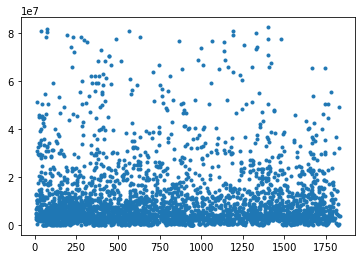

In [417]:
y.plot(style='.')

In [455]:
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
alpha_elastic = [0.0089591]
elastic = make_pipeline(StandardScaler(), ElasticNetCV(cv=None, alphas=alpha_elastic))
elastic.fit(X, y)

def estimate_total_energy(property_type, sq_footage, year):
    try:
        prop_num = uniq_dict[property_type]
    except KeyError:
        raise ValueError(f"{property_type} is not estimated")
    return elastic.predict([[prop_num, sq_footage, year]])[0]

Text(0, 0.5, 'Square Footage (ft)')

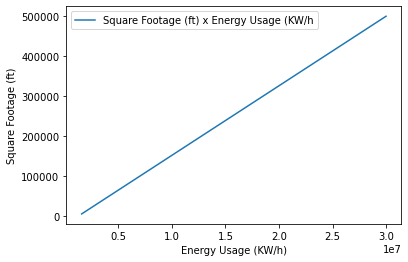

In [456]:
from matplotlib import pyplot as plt

sq_footage = np.linspace(5000, 500000, 5)
# sq_footage = np.logspace(1, 10, 5)

X = [estimate_total_energy('Multifamily Housing', sq_footage[0], 2020), estimate_total_energy('Multifamily Housing', sq_footage[1], 2020), estimate_total_energy('Multifamily Housing', sq_footage[2], 2020), estimate_total_energy('Multifamily Housing', sq_footage[3], 2020), estimate_total_energy('Multifamily Housing', sq_footage[4], 2020)]
plt.plot(X, sq_footage)
plt.legend(['Square Footage (ft) x Energy Usage (KW/h'])
plt.xlabel("Energy Usage (KW/h)")
plt.ylabel("Square Footage (ft)")
# plt.legend()


In [423]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
alpha_ridge = [14.6]
# alpha_ridge = np.linspace(.1, 1000, 100)
alpha_lasso = [190106]
# alpha_lasso = np.logspace(5, 10, 100)
alpha_elastic = [0.0089591] # 0.4347726551518415
# alpha_elastic = np.linspace(.0001, 5, 100)

# elastic
# alphas = np.linspace(.03, .06, 100)
# modal = make_pipeline(StandardScaler(), RidgeCV(cv=None, alphas=alphas, alpha_per_target=True, store_cv_values=True))
ridge = make_pipeline(StandardScaler(), RidgeCV(cv=None, alphas=alpha_ridge))
lasso = make_pipeline(StandardScaler(), LassoCV(cv=None, alphas=alpha_lasso))
elastic = make_pipeline(StandardScaler(), ElasticNetCV(cv=None, alphas=alpha_elastic))

# lasso = Lasso(random_state=0, max_ridgeiter=100000)
ridge.fit(X, y)
lasso.fit(X, y)
elastic.fit(X, y)
scores = {
    "ridge": cross_val_score(ridge, X, y, scoring="r2", cv=None),
    "elastic": cross_val_score(elastic, X, y, scoring="r2", cv=None),
    "lasso": cross_val_score(lasso, X, y, scoring="r2", cv=None)
}
print(f"Ridge avg r^2: {np.average(scores['ridge'])}")
print(f"ElasticNet avg r^2: {np.average(scores['elastic'])}")
print(f"Lasso avg r^2: {np.average(scores['lasso'])}")

Ridge avg r^2: 0.702481643027445
ElasticNet avg r^2: 0.7024709552684725
Lasso avg r^2: 0.7030448790308842
